In [9]:
import requests
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
from urllib.parse import urljoin # liens relatifs
from collections import Counter

In [10]:
def extract_urls_from_sitemap(sitemap_url):

    urls = []
    headers = {'User-Agent': 'Mozilla/5.0'}

    response = requests.get(sitemap_url, headers=headers, timeout=30)
    response.raise_for_status()
    xml_content = response.text

    namespaces = {'sm': 'http://www.sitemaps.org/schemas/sitemap/0.9'}
    root = ET.fromstring(xml_content)

    for url_element in root.findall('sm:url', namespaces):
        loc_element = url_element.find('sm:loc', namespaces)
        if loc_element is not None and loc_element.text:
            urls.append(loc_element.text.strip())

    return urls

In [11]:
target_sitemap_url = "https://www.meilleurtaux.com/sitemap/xml.html"
print(f"Extraction des URLs depuis : {target_sitemap_url}")

extracted_urls = extract_urls_from_sitemap(target_sitemap_url)

print(f"\n{len(extracted_urls)} URLs extraites :")
for url in extracted_urls:
    print(url)

with open("extracted_urls.txt", "w", encoding="utf-8") as f:
    for url in extracted_urls:
        f.write(url + "\n")
print("\nURLs sauvegardées dans extracted_urls.txt")

Extraction des URLs depuis : https://www.meilleurtaux.com/sitemap/xml.html

15607 URLs extraites :
https://www.meilleurtaux.com/financement-scpi/
https://www.meilleurtaux.com/credit-immobilier/notre-analyse-des-taux.html
https://www.meilleurtaux.com/credit-immobilier/notre-analyse-des-taux/evolution-oat-tec-10-ans.html
https://www.meilleurtaux.com/credit-immobilier/notre-analyse-des-taux/evolution-taux-directeur-bce.html
https://www.meilleurtaux.com/credit-immobilier/notre-analyse-des-taux/taux-immobilier-15-ans.html
https://www.meilleurtaux.com/credit-immobilier/notre-analyse-des-taux/taux-immobilier-20-ans.html
https://www.meilleurtaux.com/credit-immobilier/notre-analyse-des-taux/taux-immobilier-25-ans.html
https://www.meilleurtaux.com/credit-immobilier/carte-des-envies-acheter-immobilier.html
https://www.meilleurtaux.com/credit-immobilier/barometre-des-taux.html
https://www.meilleurtaux.com/credit-immobilier/index.html
https://www.meilleurtaux.com/credit-immobilier/simulation-de-pre

In [12]:
len(extracted_urls)

15607

In [13]:
def subset_urls(urls):
    return [u for u in urls if "www.meilleurtaux.com/credit-immobilier" in u]

In [14]:
extracted_urls = subset_urls(extracted_urls)
len(extracted_urls)

5108

In [15]:
def download_page_source(url):
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

        response = requests.get(url, headers=headers, timeout=15)
        response.raise_for_status()
        return response.text

    except Exception as e:
        # Attrape toute autre erreur imprévue
        print(f"Une erreur inattendue est survenue pour l'URL {url} : {e}")
        return None

In [16]:

source_code = download_page_source(extracted_urls[11])
source_code



'<!DOCTYPE html>\n<html xmlns="https://www.w3.org/1999/xhtml" xml:lang="fr-fr" lang="fr-fr" dir="ltr">\n\n<head>\n    <meta http-equiv="X-UA-Compatible" content="IE=edge" />\n    <meta name="msapplication-config" content="none" />\n    \n    <meta charset="utf-8">\n\t<meta name="description" content="Un futur projet immobilier ? En quelques clics, calculez vos mensualités avec le simulateur meilleurtaux.com">\n\t<title>Simulation APL Aide au logement - Meilleurtaux.com</title>\n\t<link href="/media/vendor/joomla-custom-elements/css/joomla-alert.min.css?0.2.0" rel="stylesheet" />\n\t<link href="/css/libs/bootstrap-grid-revfad1465.css" rel="stylesheet" />\n\t<link href="/css/ab/common-revfad1465.css" rel="stylesheet" />\n\t<link href="/css/ab/page-revfad1465.css" rel="stylesheet" />\n\t<link href="/css/ab/icons-hp-revfad1465.css" rel="stylesheet" />\n<script type="application/json" class="joomla-script-options new">{"joomla.jtext":{"MDL_MODALTXT_CLOSE":"fermer","MDL_MODALTXT_PREVIOUS":"p

In [17]:
def extract_and_clean_content(html_content):

    try:
        soup = BeautifulSoup(html_content, 'html.parser')

        extracted_data = {'description': None, 'main_content_text': None, 'main_content_html': None}

        meta_tag = soup.find('meta', attrs={'name': 'description'})
        if meta_tag and meta_tag.get('content'):
            extracted_data['description'] = meta_tag['content'].strip()
        else:
            print("Avertissement : Balise meta description non trouvée.")

        balises = ['div.item-page.actusDetail', 'div.item-page', 'div.article-full', 'div.ct-sidebar-right']
        for balise in balises:
            main_div = soup.select_one(balise)
            if main_div:
                extracted_data['main_content_text'] = main_div.get_text(separator=' ', strip=True)
                extracted_data['main_content_html'] = str(main_div)
                break
            else:
                print(f"Avertissement : La div '{balise}' n'a pas été trouvée.")

        return extracted_data

    except Exception as e:
        print(f"Erreur lors de l'analyse HTML avec BeautifulSoup : {e}")
        return {'description': None, 'main_content_text': None, 'main_content_html': None}

In [18]:
donnees_extraites = extract_and_clean_content(source_code)

print("\n[+] Meta Description Extraite :")
print(donnees_extraites.get('description', "Non trouvée"))

print("\n[+] Texte Nettoyé du Contenu Principal :")
texte_principal = donnees_extraites.get('main_content_text', "Non trouvé")
print(texte_principal[:1000] + ("..." if len(texte_principal) > 1000 else ""))

print("\n[+] Html Nettoyé du Contenu Principal :")
texte_principal = donnees_extraites.get('main_content_html', "Non trouvé")
print(texte_principal[:1000] + ("..." if len(texte_principal) > 1000 else ""))

Avertissement : La div 'div.item-page.actusDetail' n'a pas été trouvée.

[+] Meta Description Extraite :
Un futur projet immobilier ? En quelques clics, calculez vos mensualités avec le simulateur meilleurtaux.com

[+] Texte Nettoyé du Contenu Principal :
Écrit par Fabienne CORNILLON . Mis à jour le 5 mars 2024 . Temps de lecture : 7 min La promesse Meilleurtaux Chez Meilleurtaux nous aspirons à vous aider à prendre de meilleures décisions sur vos finances. Notre combat : vous rendre gagnant sur votre argent en vous donnant toutes les clés de compréhension sur nos offres. Consultez notre méthode de présentation des offres et comment nous nous rémunérons sur chacun de nos services. L’aide personnalisée au logement (APL) est une aide destinée aux locataires afin de réduire le montant de leur loyer. Comment obtenir cette aide ? Quels sont les critères d’éligibilité ? On fait le point avec vous. Qu’est-ce que l’APL ? En France, l’aide personnalisée au logement, APL, a été mise en place en 

In [19]:
def extract_links_from_html(html_fragment, base_url=None):

    soup = BeautifulSoup(html_fragment, 'html.parser')

    links = []
    try:

        for anchor_tag in soup.find_all('a', href=True):
            href = anchor_tag['href'].strip()

            if href and not href.startswith('#') and not href.lower().startswith('javascript:'):
                if base_url:
                    absolute_url = urljoin(base_url, href)
                    links.append(absolute_url)
                else:
                    links.append(href)

    except Exception as e:
        print(f"Erreur lors de l'extraction des liens depuis le fragment HTML : {e}")
        return links

    return links

In [20]:

all_links = extract_links_from_html(texte_principal, base_url=extracted_urls[411])

for u,c in Counter(all_links).items():
    print(f" {c} - {u}")


 1 - https://www.meilleurtaux.com/redaction-meilleurtaux/#fabienne-cornillon
 1 - https://www.meilleurtaux.com/credit-immobilier/simulation-de-pret-immobilier/simulation-du-pret-a-taux-zero-plus.html
 1 - https://www.meilleurtaux.com/credit-immobilier/pouvoir-achat-immobilier/combien-apl-loyer/
 1 - https://www.meilleurtaux.com/redaction-meilleurtaux/


In [21]:
data = {}

In [22]:
import random
import time

sample = random.sample(extracted_urls, 50)
for url in sample:
    source_code = download_page_source(url)
    donnees_extraites = extract_and_clean_content(source_code)
    description = donnees_extraites.get('description', "Non trouvée")
    texte = donnees_extraites.get('main_content_text', "Non trouvé")
    html = donnees_extraites.get('main_content_html', "Non trouvé")

    if html:
        all_links = extract_links_from_html(html, base_url=url)
    else:
        all_links = []

    data[url] = {'source': source_code,
                 'description': description,
                 'texte': texte,
                 'html': html,
                 'liens': all_links
                 }
    time.sleep(0.1)


Avertissement : La div 'div.item-page.actusDetail' n'a pas été trouvée.
Avertissement : La div 'div.item-page' n'a pas été trouvée.
Avertissement : Balise meta description non trouvée.
Avertissement : La div 'div.item-page.actusDetail' n'a pas été trouvée.
Avertissement : La div 'div.item-page.actusDetail' n'a pas été trouvée.
Avertissement : La div 'div.item-page.actusDetail' n'a pas été trouvée.
Avertissement : La div 'div.item-page.actusDetail' n'a pas été trouvée.
Avertissement : La div 'div.item-page' n'a pas été trouvée.
Avertissement : La div 'div.item-page.actusDetail' n'a pas été trouvée.
Avertissement : La div 'div.item-page.actusDetail' n'a pas été trouvée.
Avertissement : Balise meta description non trouvée.
Avertissement : La div 'div.item-page.actusDetail' n'a pas été trouvée.
Avertissement : La div 'div.item-page.actusDetail' n'a pas été trouvée.
Avertissement : La div 'div.item-page' n'a pas été trouvée.
Avertissement : Balise meta description non trouvée.
Avertissement

In [23]:
for k,v in data.items():
    if not v['texte']:
        if "www.meilleurtaux.com/credit-immobilier" in k:
            print(k)

# Graph

In [24]:
import networkx as nx

def build_graph_with_external_nodes(page_data_dict):

        G = nx.DiGraph()
        internal_urls = set(page_data_dict.keys())

        print(f"Adding {len(internal_urls)} internal nodes...")
        for page_url, data in page_data_dict.items():
            attributes = {
                'description': data.get('description', ''),
                'texte': data.get('texte', ''),
                'is_internal': True,
            }
            G.add_node(page_url, **attributes)

        print("Processing edges and adding external nodes...")
        external_nodes_added = set()
        for source_url, data in page_data_dict.items():
            if source_url not in internal_urls:
                continue

            outgoing_links = data.get('liens', [])
            for target_url in outgoing_links:
                if not target_url: continue

                if not G.has_node(target_url):
                    external_attributes = {
                       'description': '', 
                       'texte': '',
                       'is_internal': False, 
                    }
                    G.add_node(target_url, **external_attributes)
                    external_nodes_added.add(target_url)

                if source_url != target_url:
                    G.add_edge(source_url, target_url)

        print(f"Added {len(external_nodes_added)} external nodes.")
        print(f"Graph built successfully: {G.number_of_nodes()} total nodes, {G.number_of_edges()} edges.")

        return G

In [25]:
my_graph = build_graph_with_external_nodes(data)

if my_graph:
    print("\nGraph Info:")
    print(f"Total number of nodes: {my_graph.number_of_nodes()}")
    print(f"Total number of edges: {my_graph.number_of_edges()}")

Adding 50 internal nodes...
Processing edges and adding external nodes...
Added 164 external nodes.
Graph built successfully: 214 total nodes, 257 edges.

Graph Info:
Total number of nodes: 214
Total number of edges: 257


In [26]:
import matplotlib.pyplot as plt

def draw_graph_matplotlib(G, output_filename=None):
    print("\nPreparing graph visualization...")

    # --- Node Separation and Coloring ---
    internal_nodes = [n for n, d in G.nodes(data=True) if d.get('is_internal', False)]
    external_nodes = [n for n, d in G.nodes(data=True) if not d.get('is_internal', False)]

    # Assign colors based on the flag
    node_colors = ['skyblue' if G.nodes[n].get('is_internal', False) else 'lightcoral' for n in G.nodes()]

    print("Calculating layout (this might take a while for large graphs)...")
    try:
        # Use fewer iterations for larger graphs to speed up, potentially at cost of layout quality
        iterations = 50 if G.number_of_nodes() < 1000 else 20
        pos = nx.spring_layout(G, k=0.15, iterations=iterations, seed=42) # seed for reproducibility
        print("Layout calculation finished.")
    except Exception as e:
        print(f"Layout calculation failed ({e}), falling back to random layout.")
        pos = nx.random_layout(G, seed=42)

    # --- Drawing ---
    print("Drawing graph components...")
    plt.figure(figsize=(18, 12)) # Adjust figure size as needed

    # Draw nodes
    nx.draw_networkx_nodes(G, pos,
                           nodelist=internal_nodes,
                           node_color='skyblue', # Color for internal nodes
                           node_size=100,        # Adjust size as needed
                           label='Internal Pages') # Label for legend (if used)
    nx.draw_networkx_nodes(G, pos,
                           nodelist=external_nodes,
                           node_color='lightcoral', # Color for external nodes
                           node_size=50,         # Smaller size for external
                           label='External Links') # Label for legend (if used)

    # Draw edges
    nx.draw_networkx_edges(G, pos,
                           alpha=0.2,          # Transparency for edges
                           edge_color='gray',
                           arrows=True,        # Show direction (can clutter plot)
                           arrowstyle='->',
                           arrowsize=10)

    plt.title(f"Graph Visualization ({G.number_of_nodes()} nodes, {G.number_of_edges()} edges)")
    plt.axis('off') 
    plt.tight_layout()

    if output_filename:
        try:
            plt.savefig(output_filename, dpi=300, bbox_inches='tight')
            print(f"Graph saved to {output_filename}")
        except Exception as e:
            print(f"Error saving graph to {output_filename}: {e}")
    else:
        print("Displaying graph...")
        plt.show()



Preparing graph visualization...
Calculating layout (this might take a while for large graphs)...
Layout calculation finished.
Drawing graph components...
Displaying graph...


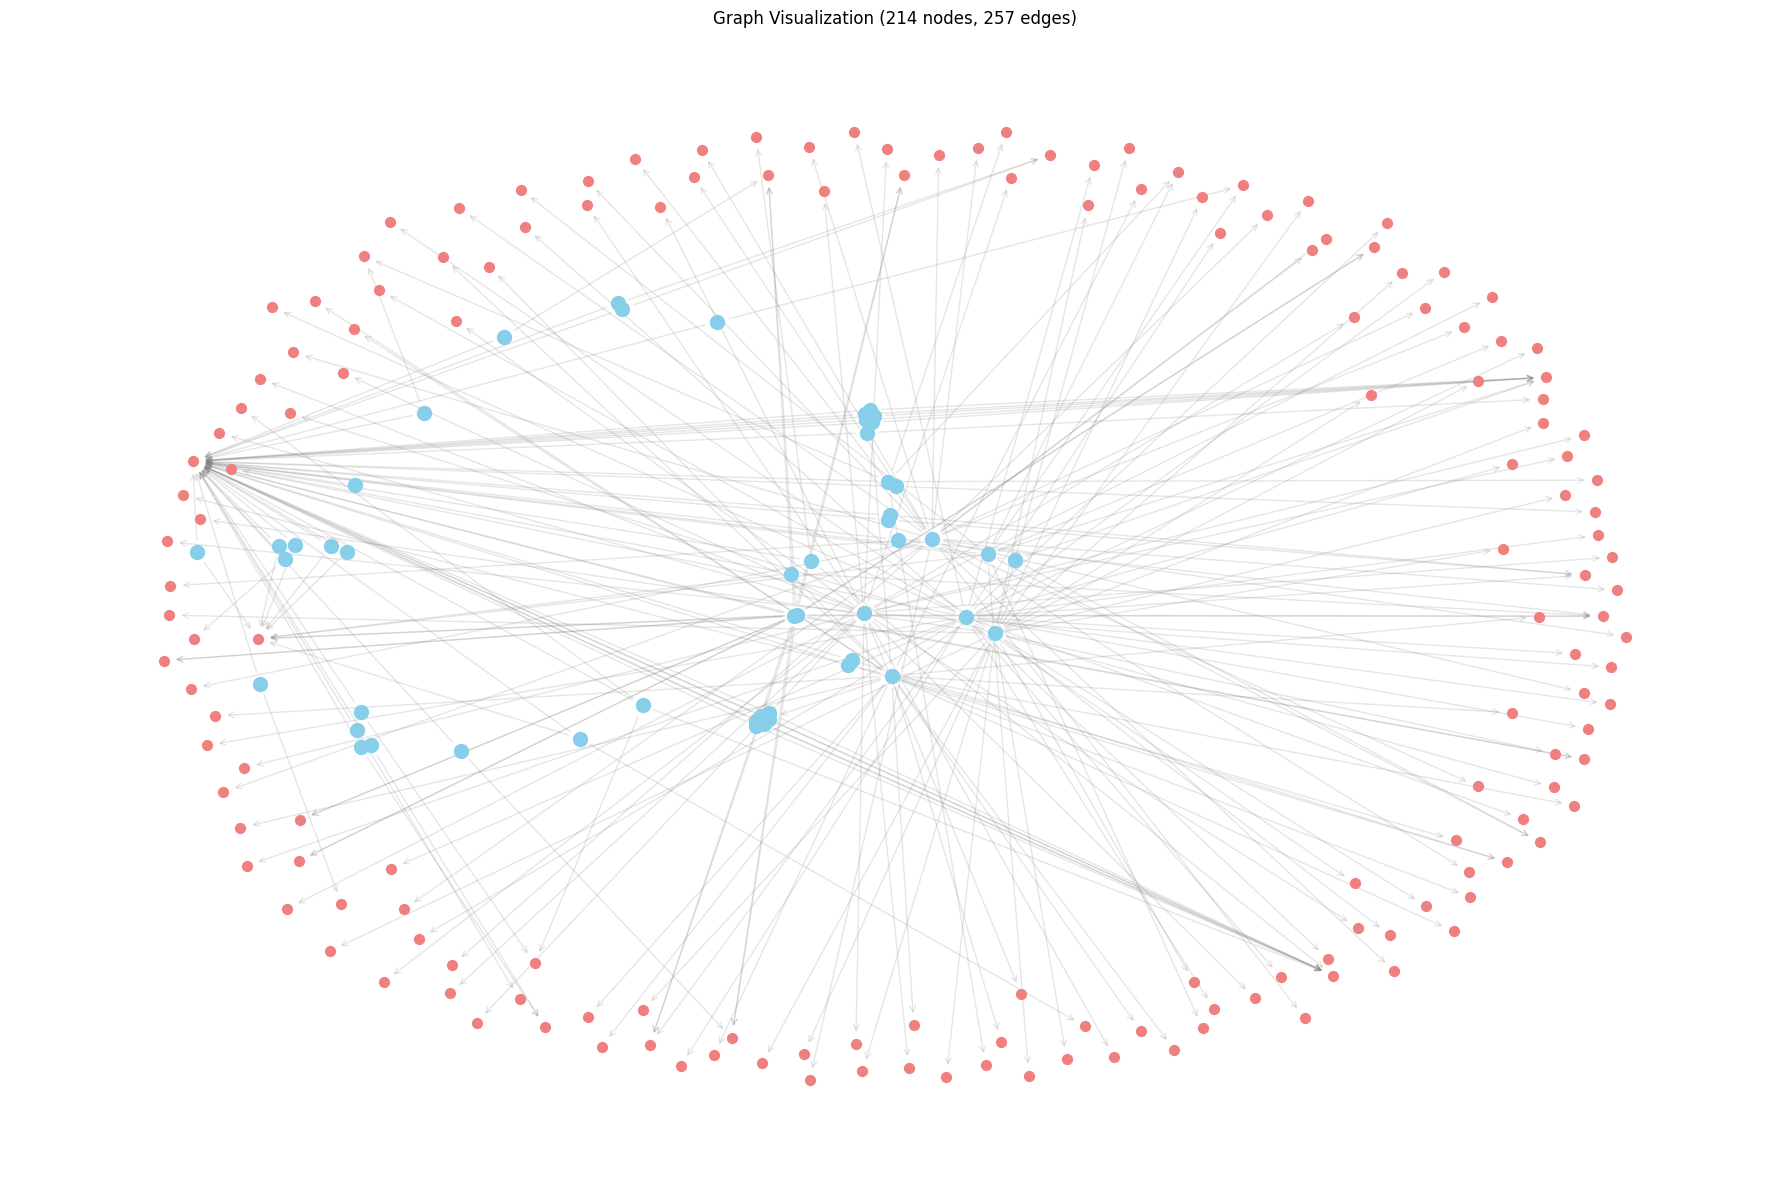

In [27]:
draw_graph_matplotlib(my_graph)

# Embeddings

In [28]:
import google.generativeai as genai
import os
import time
import datetime
from dotenv import load_dotenv # Optional: for loading .env files
# import copy # Import if you need to avoid modifying the original dict

# --- Function to add Gemini embeddings ---

def add_gemini_embeddings(page_data_dict, text_field='texte', embedding_field='embedding', model_name='models/embedding-001', task_type="RETRIEVAL_DOCUMENT"):
    """
    Computes Gemini embeddings for text content in a dictionary and adds them.

    Args:
        page_data_dict (dict): Dictionary where keys are page URLs and values
                               are dicts containing page info including a text field.
                               This dictionary WILL BE MODIFIED IN-PLACE.
        text_field (str): The key in the inner dictionary containing the text to embed.
                          Defaults to 'texte'.
        embedding_field (str): The key under which the computed embedding vector
                               will be stored. Defaults to 'embedding'.
        model_name (str): The name of the Gemini embedding model to use.
                          Check Google's documentation for available models.
                          Defaults to 'models/embedding-001'.
        task_type (str): The task type for the embedding model, crucial for optimal
                         performance. Common options:
                         "RETRIEVAL_DOCUMENT" (for documents to be retrieved/clustered)
                         "RETRIEVAL_QUERY" (for search queries)
                         "SEMANTIC_SIMILARITY" (for similarity tasks)
                         "CLASSIFICATION"
                         "CLUSTERING"
                         Defaults to "RETRIEVAL_DOCUMENT". "CLUSTERING" is also suitable.

    Returns:
        bool: True if configuration was successful and processing completed (fully or partially),
              False if configuration failed. The input dictionary is modified in-place.
    """
    print(f"Initiating Gemini embedding process...")
    print(f"  Model: {model_name}")
    print(f"  Task Type: {task_type}")
    print(f"  Input Text Field: '{text_field}'")
    print(f"  Output Embedding Field: '{embedding_field}'")

    # --- 1. Configure API Key ---
    load_dotenv()
    api_key = os.getenv("GEMINI_API_KEY")
    genai.configure(api_key=api_key)

    # --- 2. Iterate through data and compute embeddings ---
    count = 0
    success_count = 0
    skipped_count = 0
    error_count = 0
    total_pages = len(page_data_dict)
    start_time = time.time()

    print(f"\nProcessing {total_pages} pages...")

    for page_url, page_data in page_data_dict.items():
        count += 1
        progress_prefix = f"({count}/{total_pages})"

        # Option A: Skip if embedding already computed (for resuming)
        if embedding_field in page_data and page_data[embedding_field] is not None:
            # print(f"{progress_prefix} Skipping {page_url[:70]}... (already has embedding)")
            skipped_count += 1
            continue # Move to the next page

        # Option B: Overwrite existing embedding (comment out Option A if using this)
        # page_data[embedding_field] = None # Reset before trying

        # Get text content
        text_to_embed = page_data.get(text_field, ' ')

        # Validate text content
        if not text_to_embed or not isinstance(text_to_embed, str) or len(text_to_embed.strip()) == 0:
            print(f"{progress_prefix} Skipping {page_url[:70]}... (No valid text in '{text_field}')")
            page_data[embedding_field] = None # Mark as processed, no embedding possible
            skipped_count += 1
            continue

        # Compute embedding
        try:
            result = genai.embed_content(
                model=model_name,
                content=text_to_embed,
                task_type=task_type
            )

            embedding_vector = result.get('embedding')

            if embedding_vector and isinstance(embedding_vector, list):
                page_data[embedding_field] = embedding_vector
                success_count += 1
                if count % 100 == 0: # Log progress periodically
                     print(f"{progress_prefix} Processed.")
            else:
                print(f"{progress_prefix} Warning: API success for {page_url[:70]}... but no embedding vector found. Result: {result}")
                page_data[embedding_field] = None
                error_count += 1

            # --- Rate Limiting ---
            # Add a small delay to avoid hitting API rate limits (adjust as needed)
            # Check Gemini API documentation for specific limits (e.g., requests per minute)
            # Example: 60 RPM limit means 1 request per second. Be conservative.
            time.sleep(1.1) # Sleep for slightly over 1 second

        except Exception as e:
            print(f"{progress_prefix} Error embedding {page_url[:70]}... Error: {e}")
            page_data[embedding_field] = None # Mark as failed
            error_count += 1
            # Optional: Implement more robust error handling/retry logic here
            time.sleep(2) # Wait a bit longer after an error

    # --- 3. Report Summary ---
    end_time = time.time()
    duration = end_time - start_time
    print("\n--- Embedding Process Finished ---")
    print(f"Total pages considered: {total_pages}")
    print(f"Successfully embedded: {success_count}")
    print(f"Skipped (no text or already done): {skipped_count}")
    print(f"Errors during embedding: {error_count}")
    print(f"Total time taken: {duration:.2f} seconds")

    return True # Indicate completion (even with errors)


In [29]:

success = add_gemini_embeddings(data)

if success:
    print("\n--- Verification ---")
    print("Checking data after embedding attempt:")
    for url, d in data.items():
        embedding_status = "Not Processed (key missing)"
        if 'embedding' in d:
            if isinstance(d['embedding'], list):
                embedding_status = f"Success (Dim: {len(d['embedding'])})"
            elif d['embedding'] is None:
                embedding_status = "Failed or Skipped (None)"
            else:
                embedding_status = "Unexpected Value"
        print(f"- {url[:40]}... : {embedding_status}")
else:
    print("\nEmbedding process could not be configured or started.")

Initiating Gemini embedding process...
  Model: models/embedding-001
  Task Type: RETRIEVAL_DOCUMENT
  Input Text Field: 'texte'
  Output Embedding Field: 'embedding'

Processing 50 pages...

--- Embedding Process Finished ---
Total pages considered: 50
Successfully embedded: 50
Skipped (no text or already done): 0
Errors during embedding: 0
Total time taken: 71.07 seconds

--- Verification ---
Checking data after embedding attempt:
- https://www.meilleurtaux.com/credit-immo... : Success (Dim: 768)
- https://www.meilleurtaux.com/credit-immo... : Success (Dim: 768)
- https://www.meilleurtaux.com/credit-immo... : Success (Dim: 768)
- https://www.meilleurtaux.com/credit-immo... : Success (Dim: 768)
- https://www.meilleurtaux.com/credit-immo... : Success (Dim: 768)
- https://www.meilleurtaux.com/credit-immo... : Success (Dim: 768)
- https://www.meilleurtaux.com/credit-immo... : Success (Dim: 768)
- https://www.meilleurtaux.com/credit-immo... : Success (Dim: 768)
- https://www.meilleurtaux.

In [31]:
import json

with open('result.json','w') as f:
    json.dump(data,f)